In [19]:
import pandas as pd
pd.options.mode.chained_assignment = None

raw_data = pd.read_csv("LendingClub2012to2013.csv", low_memory = False, skiprows=[0])

#  take out the non-fully paid off loans
print(raw_data['loan_status'].unique())
print(raw_data.shape)

['Fully Paid' 'Current' 'Charged Off' 'Late (31-120 days)'
 'In Grace Period' 'Late (16-30 days)' 'Default' nan]
(188183, 115)


In [20]:
# Eliminate the rows that aren't "complete"
# Dropping current loans and the ones that are a few months late and leave behind the defaults and the paid off loans
no_incomplete_rows = raw_data[raw_data['loan_status'].isin(['Fully Paid', 'Charged Off', 'Default'])]
no_incomplete_rows['loan_status'] = no_incomplete_rows['loan_status'].apply(lambda x: 0 if x == "Fully Paid" else 1)
no_incomplete_rows.shape

no_incomplete_rows.to_csv("test.csv", index = False) 

In [21]:
# remove leakage
customer_id = ['id']
leakage_to_drop = ['recoveries', 'collection_recovery_fee', 'last_fico_range_high', 'last_fico_range_low', 'last_credit_pull_d', 'total_rec_prncp', 'last_pymnt_amnt', 'total_pymnt', 'total_pymnt_inv', 'last_pymnt_d', 'total_rec_late_fee', 'total_rec_int', 'num_tl_120dpd_2m', 'num_tl_30dpd', 'out_prncp', 'out_prncp_inv', 'pymnt_plan', 'next_pymnt_d']

no_information_features_to_drop = ['all_util', 'dti_joint', 'il_util', 'inq_fi', 'inq_last_12m', 'max_bal_bc', 'mths_since_rcnt_il', 'open_acc_6m', 'open_il_12m', 'open_il_24m', 'open_il_6m', 'open_rv_12m', 'open_rv_24m', 'total_bal_il', 'verification_status_joint', 'annual_inc_joint', 'application_type',  'policy_code', 'total_cu_tl']

no_leakage = no_incomplete_rows.drop(no_information_features_to_drop + no_information_features_to_drop + customer_id, axis = 1)

no_leakage.to_csv("test.csv", index = False)

In [30]:
import numpy as np

In [31]:
from sklearn import preprocessing
from sklearn import model_selection
import numpy as np

variables_i_want_to_try = ['int_rate', 'grade', 'term', 'fico_range_high','loan_amnt','dti']
df = no_leakage[variables_i_want_to_try]

#create some dummy variables
term_dummies = pd.get_dummies(df['term'], prefix="term_")
grade_dummies = pd.get_dummies(df['grade'], prefix="grade")

#combine the dummies back in
df = pd.concat([df, term_dummies, grade_dummies], axis=1)
#rename the term columns
df.rename(columns={'term__ 36 months': 'term_36_months', 'term__ 60 months': 'term_60_months'}, inplace=True)

# remove % symbol from interest rate variable
df['int_rate'] = df['int_rate'].apply(lambda x: x.strip('%'))

# pick variables that I want to keep
variables_with_dummies = ['int_rate', 'term_36_months', 'term_60_months','fico_range_high', 'grade_A', 'grade_B', 'grade_C', 'grade_D', 'grade_E', 'grade_F', 'grade_G', 'loan_amnt','dti']

X = df[variables_with_dummies]
y = no_leakage['loan_status']

#cross validation

cv = model_selection.KFold(5)
lr = linear_model.LogisticRegression(C=1000000000000)
# model_selection.cross_val_score(lr, X, y, cv=cv, scoring='roc_auc')

included = []
score_values = [0.5]


while len(included) < len(variables_with_dummies):
    score = 0.5
    best = ""
    for i in variables_with_dummies:
        if i not in included:
            attempt = included + [i]
            new_score = np.mean(model_selection.cross_val_score(lr, X[attempt], y, cv=cv, scoring='roc_auc'))
            print("     %s: %f" %(str(attempt), new_score))
            if new_score > score: 
                best = i
                score = new_score
    included = included + [best]
    score_values = score_values + [score]
    print("Best model for this round: %s: %f" %(str(included), score))


     ['int_rate']: 0.677046
     ['term_36_months']: 0.603925
     ['term_60_months']: 0.603925
     ['fico_range_high']: 0.588323
     ['grade_A']: 0.563553
     ['grade_B']: 0.564159
     ['grade_C']: 0.524129
     ['grade_D']: 0.540717
     ['grade_E']: 0.534973
     ['grade_F']: 0.522754
     ['grade_G']: 0.505139
     ['loan_amnt']: 0.527339
     ['dti']: 0.568756
Best model for this round: ['int_rate']: 0.677046
     ['int_rate', 'term_36_months']: 0.689433
     ['int_rate', 'term_60_months']: 0.689433
     ['int_rate', 'fico_range_high']: 0.672948
     ['int_rate', 'grade_A']: 0.677043
     ['int_rate', 'grade_B']: 0.677045
     ['int_rate', 'grade_C']: 0.677068
     ['int_rate', 'grade_D']: 0.677011
     ['int_rate', 'grade_E']: 0.677020
     ['int_rate', 'grade_F']: 0.677046
     ['int_rate', 'grade_G']: 0.677044
     ['int_rate', 'loan_amnt']: 0.351421
     ['int_rate', 'dti']: 0.682104
Best model for this round: ['int_rate', 'term_36_months']: 0.689433
     ['int_rate', 'ter

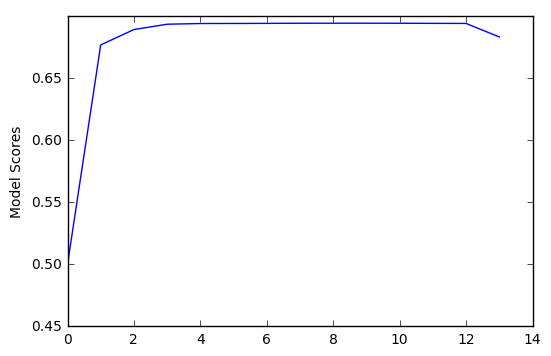

In [32]:
plt.plot(score_values)
plt.ylabel('Model Scores')
plt.show()
